Testing Accuracy: 0.70


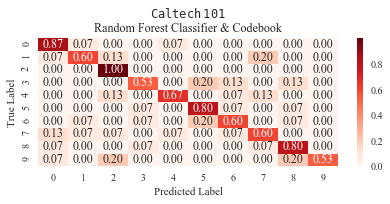

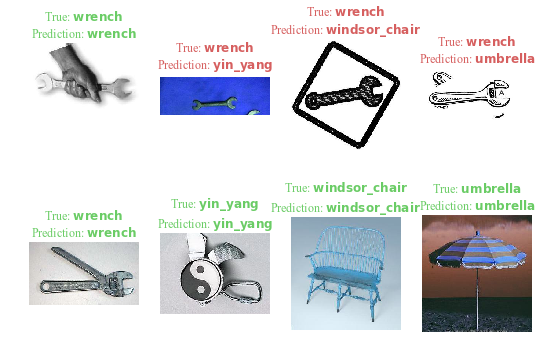

In [5]:
# EXECUTION TIME: 17s

# Python 3 ImportError
import sys
sys.path.append('.')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import typing
import time
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import src as ya

# prettify plots
plt.rcParams['font.family'] = 'Times New Roman'
# sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

b_sns, g_sns, r_sns, p_sns, y_sns, l_sns = sns.color_palette("muted")

random_state = 0

np.random.seed(random_state)

# fetch data
data_train, data_query = ya.data.getCaltech(codebook="random-forest",
                                            num_descriptors=100000,
                                            pickle_load=False,
                                            pickle_dump=False,
                                            num_features=8)

# fetch raw images
images = ya.data.getCaltech_images(random_state=0)

# class list in str
class_list = ya.data.getCaltech_classlist(
    'data/Caltech_101/101_ObjectCategories')

X_train, y_train = data_train[:, :-1], data_train[:, -1]
X_test, y_test = data_query[:, :-1], data_query[:, -1]

###########################################################################
# Validation of Hyperparameters
###########################################################################

# Best Parameters
best_params_ = {'n_estimators': 300,
                'max_depth': 14,
                'min_samples_split': 6 ,
                'min_impurity_decrease': 0.00,
                'max_features': 2
                }

# "optimal" classifier
clf = RandomForestClassifier(**best_params_).fit(X_train, y_train)

# predictions
y_hat = clf.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_hat)
ya.visualise.plot_confusion_matrix(cm, normalize=True,
                                   title='$\\mathtt{Caltech\ 101}$\nRandom Forest Classifier & Codebook',
                                   savefig='3.3/optimal_confusion_matrix', cmap=plt.cm.Reds)

print('Testing Accuracy: %.2f' % clf.score(X_test, y_test))

# most miss-classified class
ij_min = cm.diagonal().argmin()
# most correctly classified class
ij_max = cm.diagonal().argmax()
# get diagonal entries
idx = np.eye(cm.shape[0], dtype=bool)

# logically ignore diagonal elements
cm_mod = np.copy(cm)
np.fill_diagonal(cm_mod, 16)

# miss-classified
idx_min = np.argsort(cm_mod[ij_min])[::-1]

# number of samples
num_samples = 3

# figures
fig, axes = plt.subplots(ncols=num_samples+1, nrows=2,
                         figsize=(3.0 * num_samples, 6.0))
axes = axes.flatten()
# training example
axes[0].imshow(images['train'][15 * ij_min], interpolation='nearest')
axes[0].set_axis_off()
axes[0].set_title(
    'True: $\\mathbf{%s}$\nPrediction: $\\mathbf{%s}$' % (class_list[ij_min],
                                                          class_list[ij_min]),
    color=g_sns)
axes[1+num_samples].imshow(images['train'][15 * ij_min + 1],
                           interpolation='nearest')
axes[1+num_samples].set_axis_off()
axes[1+num_samples].set_title(
    'True: $\\mathbf{%s}$\nPrediction: $\\mathbf{%s}$' % (class_list[ij_min],
                                                          class_list[ij_min]),
    color=g_sns)
for z in range(num_samples):
    # miss-classified
    wrong_samples = np.where((y_hat == idx_min[z+1]) & (y_test == ij_min))
    axes[z+1].imshow(images['test'][wrong_samples][0], interpolation='nearest')
    _true = class_list[ij_min].replace('_', '\_')
    _pred = class_list[idx_min[z+1]].replace('_', '\_')
    axes[z+1].set_title(
        'True: $\\mathbf{%s}$\nPrediction: $\\mathbf{%s}$' % (_true, _pred),
        color=r_sns)
    axes[z+1].set_axis_off()

    # correctly classified
    correct_samples = np.where(
        (y_hat == idx_min[z+1]) & (y_test == idx_min[z+1]))
    axes[z+2+num_samples].imshow(images['test'][correct_samples]
                                 [0], interpolation='nearest')
    axes[z+2+num_samples].set_title(
        'True: $\\mathbf{%s}$\nPrediction: $\\mathbf{%s}$' % (_pred, _pred),
        color=g_sns)
    axes[z+2+num_samples].set_axis_off()

fig.savefig('assets/3.3/examples.pdf', format='pdf',
            dpi=300, transparent=True, bbox_inches='tight', pad_inches=0.01)
plt.show()

In [3]:
def normalize(arr):
    row_sums = arr.sum(axis=1)
    return arr/row_sums[:, np.newaxis]

In [4]:
import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

trace = go.Heatmap(
    z=normalize(cm)
)

data=[trace]

fig = go.Figure(data=data)

plotly.offline.iplot(fig)
plotly.io.write_image(fig, 'assets/3.3/optimal_confusion_matrix_plotly.pdf')

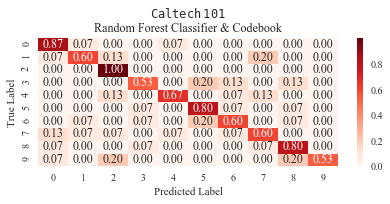

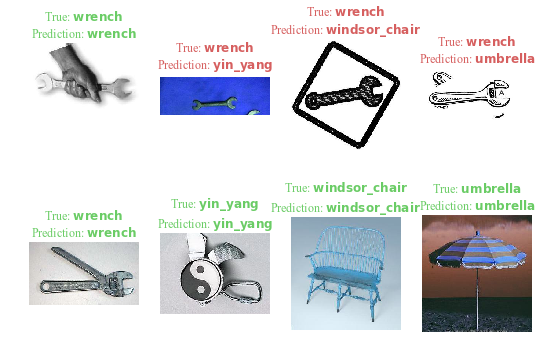

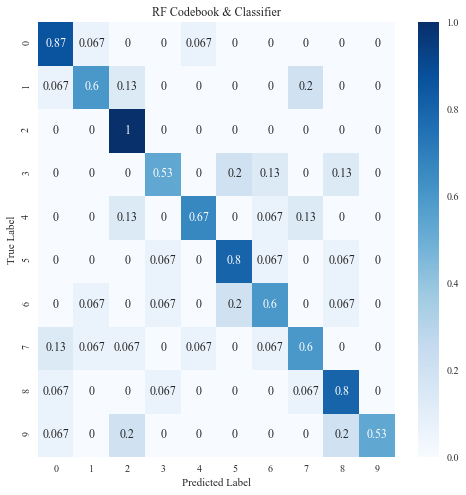

In [5]:
import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("RF Codebook & Classifier")
heatmap = sns.heatmap(normalize(cm), annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('assets/3.3/optimal_confusion_matrix_seaborn.pdf', fmt='.2f')
plt.show()